In [1]:
import psycopg2
import mplleaflet

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point

In [2]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username
dbname = 'map_the_vote'
username = 'codyschank' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://codyschank@localhost/map_the_vote
True


In [3]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [4]:
sql_query = """
SELECT * FROM voter_file_tx25_all;
"""
voter_file = pd.read_sql_query(sql_query,con)

In [5]:
sql_query = """
SELECT openaddress_street_address, zip5 FROM tx25_join WHERE voter_file_vanid IS NULL;
"""
unregistered_addresses = pd.read_sql_query(sql_query,con)
unregistered_addresses.to_csv("/Users/codyschank/Dropbox/Insight/unregistered_addresses.csv")

In [7]:
sql_query = """
SELECT openaddress_street_address, zip5 FROM tx25_join WHERE voter_file_vanid IS NOT NULL;
"""
registered_addresses = pd.read_sql_query(sql_query,con)
registered_addresses.to_csv("/Users/codyschank/Dropbox/Insight/registered_addresses.csv")

In [9]:
sql_query = """
SELECT * FROM tx25_join_check WHERE geom IS NULL;
"""
voters_not_joined = pd.read_sql_query(sql_query,con)
voters_not_joined.to_csv("/Users/codyschank/Dropbox/Insight/voters_not_joined.csv")
# Voters not matched to an address

In [10]:
sql_query = """
SELECT * FROM unregistered_addresses_by_vtd;
"""
unregistered_addresses_by_vtd = pd.read_sql_query(sql_query,con)

In [11]:
unregistered_addresses_by_vtd_count = unregistered_addresses_by_vtd.groupby('cntyvtd').size().to_frame()
unregistered_addresses_by_vtd_count.columns = ['unregistered_addresses']

In [12]:
sql_query = """
SELECT * FROM registered_addresses_by_vtd;
"""
registered_addresses_by_vtd = pd.read_sql_query(sql_query,con)

In [13]:
registered_addresses_by_vtd_count = registered_addresses_by_vtd.groupby('cntyvtd').size().to_frame()
registered_addresses_by_vtd_count.columns = ['registered_addresses']

In [14]:
voters_not_joined_by_vtd_count = voters_not_joined.groupby('cntyvtd').size().to_frame()
voters_not_joined_by_vtd_count.columns = ['voters_not_joined']
all_voters_by_vtd_count = voter_file.groupby('cntyvtd').size().to_frame()
all_voters_by_vtd_count.columns = ['all_voters']

In [16]:
sql_query = """
SELECT * FROM vtds_tx;
"""
vtds_from_sql_gd = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')

In [17]:
# do inner join first on unregistered addresses so that we end up with just TX 25
vtds_join_temp1 = pd.merge(vtds_from_sql_gd, unregistered_addresses_by_vtd_count, how="inner", on = 'cntyvtd')
vtds_join_temp2 = pd.merge(vtds_join_temp1, registered_addresses_by_vtd_count, how="left", on = 'cntyvtd')
vtds_join_temp3 = pd.merge(vtds_join_temp2, voters_not_joined_by_vtd_count, how="left", on = 'cntyvtd')
vtds_join = pd.merge(vtds_join_temp3, all_voters_by_vtd_count, how="left", on = 'cntyvtd')

In [18]:
vtds_join['total_addresses'] = vtds_join.unregistered_addresses + vtds_join.registered_addresses
vtds_join['registration_rate'] = vtds_join.registered_addresses / vtds_join.total_addresses
vtds_join['percent_ang_vap'] = vtds_join.e_angvap / vtds_join.e_vap
vtds_join['percent_hsp_vap'] = vtds_join.e_hspvap / vtds_join.e_vap
vtds_join['percent_blak_vap'] = vtds_join.e_blakvap / vtds_join.e_vap
vtds_join['percent_minority_vap'] = (vtds_join.e_blakvap + vtds_join.e_hspvap + vtds_join.e_bhvap) / vtds_join.e_vap
vtds_join['voters_not_joined_percent'] = vtds_join['voters_not_joined'] / vtds_join['all_voters']

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


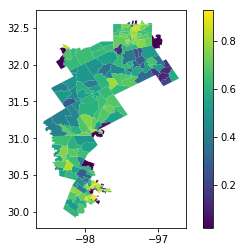

In [19]:
plot = vtds_join.plot(column='registration_rate', legend=True)
fig = plot.get_figure()
fig.savefig("/Users/codyschank/Dropbox/Insight/registration_rate.png", bbox_inches='tight', dpi = 300)

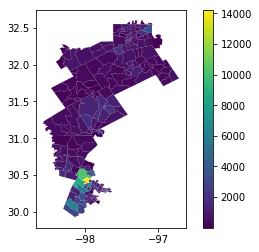

In [20]:
plot = vtds_join.plot(column='unregistered_addresses', legend=True)
fig = plot.get_figure()
fig.savefig("/Users/codyschank/Dropbox/Insight/unregistered_addresses.png", bbox_inches='tight', dpi = 300)

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


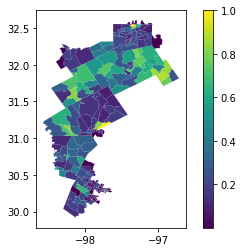

In [21]:
# Investigate precinct gaps
plot = vtds_join.plot(column='voters_not_joined_percent', legend=True)
fig = plot.get_figure()
fig.savefig("/Users/codyschank/Dropbox/Insight/voters_not_joined_percent.png", bbox_inches='tight', dpi = 300)

In [22]:
sql_query = """
SELECT * FROM tx25_join WHERE voter_file_vanid IS NULL;
"""
addresses_not_joined = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')

In [23]:
sql_query = """
SELECT * FROM vtds_tx WHERE cntyvtd = '4530251'
"""
my_precinct = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')

In [24]:
my_precinct_not_joined = gpd.sjoin(addresses_not_joined,my_precinct, how = "inner")

In [25]:
# could use mplleaflet or folium it appears
# crashes on the whole district
# slow for one precinct, but works
# very fast for street level
my_precinct_not_joined.plot(color="red")
mplleaflet.show()

In [100]:
my_precinct_not_joined.head()

,geom,openaddress_street_address,index,voter_file_vanid,sex,age,datereg,streetno,streetnohalf,streetprefix,...,e_hsp,e_total,e_vap,e_blak,e_bh,e_angvap,e_hspvap,e_bhvap,e_blakvap,e_othvap
92,POINT (-97.772583 30.2833173),2407 W 9TH ST 78703,None,None,None,None,None,None,None,None,...,526,4908,3901,132,635,2844,387,459,83,598
185,POINT (-97.77235709999999 30.2781138),2400 1/2 LAKE AUSTIN BLVD 78703,None,None,None,None,None,None,None,None,...,526,4908,3901,132,635,2844,387,459,83,598
188,POINT (-97.77398690000001 30.2794668),2530 LAKE AUSTIN BLVD 78703,None,None,None,None,None,None,None,None,...,526,4908,3901,132,635,2844,387,459,83,598
189,POINT (-97.77397929999999 30.2794616),2530 LAKE AUSTIN BLVD 78703,None,None,None,None,None,None,None,None,...,526,4908,3901,132,635,2844,387,459,83,598
672,POINT (-97.7685113 30.2823366),2109 W 10TH ST 78703,None,None,None,None,None,None,None,None,...,526,4908,3901,132,635,2844,387,459,83,598


In [104]:
my_precinct_not_joined.head()

,geom,openaddress_street_address,index,voter_file_vanid,sex,age,datereg,streetno,streetnohalf,streetprefix,...,e_total,e_vap,e_blak,e_bh,e_angvap,e_hspvap,e_bhvap,e_blakvap,e_othvap,lon
92,POINT (-97.772583 30.2833173),2407 W 9TH ST 78703,None,None,None,None,None,None,None,None,...,4908,3901,132,635,2844,387,459,83,598,-97.772583
185,POINT (-97.77235709999999 30.2781138),2400 1/2 LAKE AUSTIN BLVD 78703,None,None,None,None,None,None,None,None,...,4908,3901,132,635,2844,387,459,83,598,-97.772357
188,POINT (-97.77398690000001 30.2794668),2530 LAKE AUSTIN BLVD 78703,None,None,None,None,None,None,None,None,...,4908,3901,132,635,2844,387,459,83,598,-97.773987
189,POINT (-97.77397929999999 30.2794616),2530 LAKE AUSTIN BLVD 78703,None,None,None,None,None,None,None,None,...,4908,3901,132,635,2844,387,459,83,598,-97.773979
672,POINT (-97.7685113 30.2823366),2109 W 10TH ST 78703,None,None,None,None,None,None,None,None,...,4908,3901,132,635,2844,387,459,83,598,-97.768511
